# Complex Exponentiation of $HeH^+$ molecule via Cartan Decomposition

# Introduction

Quantum circuits are a means of translating various algorithms to work on a quantum computer. These circuits are equivalent to unitary transformations under $SU(2^n)$ for $n$ qubits. One particular unitary that plays a major role in simulating quantum systems on quantum computers is Hamiltonian evolution. In the case of the time-independent Hamiltonian, this involves utilizing the Unitary $U(t)=e^{-i\mathcal{H}t}$, which solves the time-independent Schrodinger equation. Due to the exponentially increasing complexity that arises from the increasing qubits, numerous techniques have been developed to reduce circuit length, resulting in reduced error and improved execution time.

In this project, we examine an alternative to the Trotter decomposition to estimate the time evolution of a time-independent Hamiltonian. This is accomplished through the use of a method known as Cartan decomposition, a procedure by which we can decompose a Hamiltonian algebra into smaller subalgebras. To accomplish this, we shall follow the procedure implemented in [**Fixed Depth Hamiltonian Simulation via Cartan Decomposition**](https://arxiv.org/abs/2104.00728) by Efekan Kökcü et al., utilising their [Cartan Quantum Synthesizer (CQS) program](https://github.com/kemperlab/cartan-quantum-synthesizer).


Using the $HeH^+$ molecule, we shall compare our Hamiltonian evolution of the Cartan decomposition to that of the Trotter decomposition on multiple devices to allow for possible benchmarking: the Pennylane default device, the Pennylane "lightning" device, the NVIDIA "lightning" device, and the Amazon Web Services (AWS) devices (braket.local.qubit, Amazon SV1, Ionq Aria 1, OQC Lucy). The number of Trotter steps for each device shall be chosen such that the given depth of the circuit will match that of the Cartan decomposition on those devices, allowing an accurate comparison.  

Our results will show that on all devices, the Cartan decomposition yields a significantly smaller error at a given depth compared to Trotterisation when compared to the exact Unitary (an error of $O(10^{-5})$ compared to $O(10^{0}))$. While we didn't run Quantum Phase Estimation in this notebook for this molecule, it could be done similarly to what we did in the $H_2$ notebook with the same expected advantageous results.

  For an arbitrary Hamiltonian $\mathcal{H}$, a **Cartan decomposition** of
    a Lie Algebra
    $\mathfrak{g}(\mathcal{H})$ is defined as the orthogonal decomposition $\mathfrak{g}=k \oplus m$ satisfying
 $$\begin{align}
    [k, k] &\subset k\\
    [m, m] &\subset k\\
    [k,m] &= m
\end{align}$$
Note that our Hamiltonian algebra  $\mathfrak{g}(\mathcal{H})$ is actually a subalgebra of  $SU(2^n)$. A **Cartan subalgebra** denoted by $\mathfrak{h}$ refers to a maximal Abelian algebra within $m$.


This decomposition allows us to work in smaller, simpler subgroups of the Lie algebra, which makes the calculations much easier. 

# Outline of technique

Three steps are required in order to utilize the Cartan decomposition.

1. We must construct our Hamiltonian algebra $\mathfrak{g}({\cal H})$
2.  We must find our Cartan decomposition such that ${\cal H}\in m$, as well as our associated subalgebra $\mathfrak{h}$. This can be decomposed to the form $U(t)=e^{-i\mathcal{H}t}=Ke^{-iht}K^{\dagger} $, for $K\in e^{ik}$ and $h \in \mathfrak{h}$.
3.  Finally, we must determine our element $K$. $K$ can be decomposed into $ K = \prod_{i} e^{i a_i k_i}$, where $k_i$ is an element of the Pauli string basis for $k$, which will be the basis of the implementation of the Cartan decomposition circuit. See the figure below.

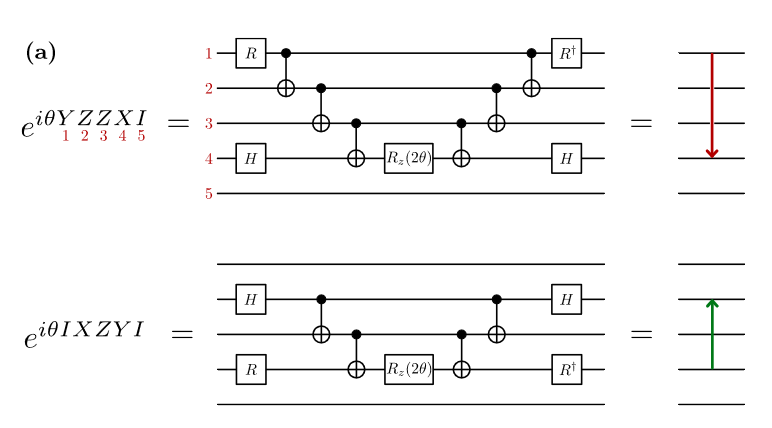

Circuit implementation of exponential of Pauli String, building blocks of Cartan decomposition and Trotterisation circuits. Taken from figure 3 of [Fixed Depth Hamiltonian Simulation via Cartan Decomposition](https://arxiv.org/abs/2104.00728).

# Constructing Hamiltonian


We begin with our first step of constructing our Hamiltonian algebra. To begin, we utilize Pennylane's database to retrieve the Hamiltonian for $H_2$ in terms of the Pauli gates.

In [3]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# use pennylane dataset for the linear H2 at bond length 1.1
hehpdatasets = qml.data.load('qchem', molname="HeH+" , basis="STO-3G", bondlength=1.1)

hamiltonian = hehpdatasets[0].hamiltonian

# get the qubits
qubits = len(hamiltonian.wires)
#return Hamiltonian and qubits
print("Number of qubits needed:", qubits)
print("Hamiltonian:\n", hamiltonian)



Number of qubits needed: 4
Hamiltonian:
   (-1.8132435973748402) [I0]
+ (0.2220985063459806) [Z3]
+ (0.22209850634598063) [Z2]
+ (0.7130930746329185) [Z1]
+ (0.7130930746329187) [Z0]
+ (-0.017466803061272948) [Y1 Y3]
+ (-0.017466803061272948) [X1 X3]
+ (0.04327270181199605) [Y0 Y2]
+ (0.04327270181199605) [X0 X2]
+ (0.10685579694085462) [Z0 Z2]
+ (0.10685579694085462) [Z1 Z3]
+ (0.1325146110440808) [Z0 Z3]
+ (0.1325146110440808) [Z1 Z2]
+ (0.1866218884781578) [Z2 Z3]
+ (0.23963614131431007) [Z0 Z1]
+ (0.06073950440097956) [Y1 Z2 Y3]
+ (0.06073950440097956) [X1 Z2 X3]
+ (0.060739504400979576) [Y0 Z1 Y2]
+ (0.060739504400979576) [X0 Z1 X2]
+ (-0.02565881410322618) [Y0 Y1 X2 X3]
+ (-0.02565881410322618) [X0 X1 Y2 Y3]
+ (-0.017466803061272948) [Y0 Z1 Y2 Z3]
+ (-0.017466803061272948) [X0 Z1 X2 Z3]
+ (0.02565881410322618) [Y0 X1 X2 Y3]
+ (0.02565881410322618) [X0 Y1 Y2 X3]
+ (0.04327270181199605) [Z0 Y1 Z2 Y3]
+ (0.04327270181199605) [Z0 X1 Z2 X3]


We import the required modules from Cartan Quantum Synthesizer(CQS), a program that we use to compute the Cartan decomposition. In order for our Hamiltonian to be read by CQS, it first must be converted into a readable format. This is achieved by converting the Pauli symbols to integers, and then separating the coefficients from  the operators. 

In [5]:
from CQS.methods import *
#We will also use:
import numpy as np

from CQS.util.IO import tuplesToMatrix
from CQS.util.verification import *
import openfermion
from openfermion import FermionOperator

In [6]:
def convert_to_cqs(hamiltonian_terms, qubits):
    """
    Converts a list of Hamiltonian terms into the format required by CQS.

    Args:
        hamiltonian_terms (list): A list of Hamiltonian terms in the format "<coefficient> <operators>",
                                  where <coefficient> is a float and <operators> is a string of operators.
                                  Each operator is represented by a symbol (I, X, Y, Z) followed by an index.
                                  
        qubits (int): The number of qubits required to represent the Hamiltonian.

    Returns:
        tuple: A tuple containing two lists. The first list contains the coefficients of the Hamiltonian terms,
               and the second list contains tuples representing the operators for each term.
               Each operator tuple is a list of integers, where each integer represents the operator type
               (0 for identity, 1 for X, 2 for Y, 3 for Z) for a specific qubit.

    """
    # Mapping from operator symbols to integers for CQS
    op_map = {'I': 0, 'X': 1, 'Y': 2, 'Z': 3}

    # Lists to hold the coefficients and operator tuples for each term
    coefs = []
    ops = []

    # Process each term in the Hamiltonian
    for term in hamiltonian_terms:
        coef, operators = term.strip().split(' ', 1)
        coef = float(coef.strip('()'))  # Strip parentheses before converting to float

        # Initialize operator tuple for this term with identity operators for all qubits
        op_tuple = [0] * qubits

        # Process each operator in the term
        if operators != '[]':  # Check if there are any operators
            # Remove brackets and split the operators
            op_list = operators[1:-1].split()
            for op in op_list:
                op_type, op_idx = op[0], int(op[1:])  # Extract operator type and index
                op_tuple[op_idx] = op_map[op_type]  # Map the operator to its integer representation

        # Append the coefficient and operator tuple to their respective lists
        coefs.append(coef)
        ops.append(tuple(op_tuple))

    return coefs, ops

str_hamiltonian=str(hamiltonian)

# Step 2: Split the string into individual terms
terms = str_hamiltonian.strip().split('\n+ ')

# Step 3 and 4: Trim whitespace and encapsulate each term in quotes
hamiltonian_terms = [f"{term.strip()}" for term in terms]

# show the resulted hamiltonian form
convert_to_cqs(hamiltonian_terms, qubits)



([-1.8132435973748402,
  0.2220985063459806,
  0.22209850634598063,
  0.7130930746329185,
  0.7130930746329187,
  -0.017466803061272948,
  -0.017466803061272948,
  0.04327270181199605,
  0.04327270181199605,
  0.10685579694085462,
  0.10685579694085462,
  0.1325146110440808,
  0.1325146110440808,
  0.1866218884781578,
  0.23963614131431007,
  0.06073950440097956,
  0.06073950440097956,
  0.060739504400979576,
  0.060739504400979576,
  -0.02565881410322618,
  -0.02565881410322618,
  -0.017466803061272948,
  -0.017466803061272948,
  0.02565881410322618,
  0.02565881410322618,
  0.04327270181199605,
  0.04327270181199605],
 [(0, 0, 0, 0),
  (0, 0, 0, 3),
  (0, 0, 3, 0),
  (0, 3, 0, 0),
  (3, 0, 0, 0),
  (0, 2, 0, 2),
  (0, 1, 0, 1),
  (2, 0, 2, 0),
  (1, 0, 1, 0),
  (3, 0, 3, 0),
  (0, 3, 0, 3),
  (3, 0, 0, 3),
  (0, 3, 3, 0),
  (0, 0, 3, 3),
  (3, 3, 0, 0),
  (0, 2, 3, 2),
  (0, 1, 3, 1),
  (2, 3, 2, 0),
  (1, 3, 1, 0),
  (2, 2, 1, 1),
  (1, 1, 2, 2),
  (2, 3, 2, 3),
  (1, 3, 1, 3),
  (2

We can now construct our Hamiltonian algebra in a format readableby the program. 

In [7]:
#Now, we can put all this together:

#Step 1: Create an Empty Hamiltonian Object
MolH = Hamiltonian(qubits)

#Use Hamiltonian.addTerms to build the Hamiltonian:
MolH.addTerms(convert_to_cqs(hamiltonian_terms, qubits))
#For convinence, we decide to remove an identity term, which only introduces a global phase 
MolH.removeTerm((0,0,0,0))
#This gives:
MolH.getHamiltonian(type='printText')

0.2220985063459806 * IIIZ
0.22209850634598063 * IIZI
0.7130930746329185 * IZII
0.7130930746329187 * ZIII
-0.017466803061272948 * IYIY
-0.017466803061272948 * IXIX
0.04327270181199605 * YIYI
0.04327270181199605 * XIXI
0.10685579694085462 * ZIZI
0.10685579694085462 * IZIZ
0.1325146110440808 * ZIIZ
0.1325146110440808 * IZZI
0.1866218884781578 * IIZZ
0.23963614131431007 * ZZII
0.06073950440097956 * IYZY
0.06073950440097956 * IXZX
0.060739504400979576 * YZYI
0.060739504400979576 * XZXI
-0.02565881410322618 * YYXX
-0.02565881410322618 * XXYY
-0.017466803061272948 * YZYZ
-0.017466803061272948 * XZXZ
0.02565881410322618 * YXXY
0.02565881410322618 * XYYX
0.04327270181199605 * ZYZY
0.04327270181199605 * ZXZX


# Cartan decomposition
Our Hamiltonian algebra $\mathfrak{g}(\mathcal{H})$ is a closed Lie algebra, and so can be split into two components $k$ and $m$ based on an involution. Various involutions are possible, but they must be chosen such that $\mathcal{H} \in m $. 

In [8]:
#Be careful choosing an involution, because it might now decompose such that the Hamiltonian is in M:
try: #attempt an involution for the given Hamiltonian
    MolC = Cartan(MolH, involution='countX') #separate based on the Pauli matrices of X. Odd count goes in k, even count goes in m
except Exception as e: #if the involution fails, fallback on separating based on Pauli Y matrices
    print('Default Even/Odd Involution does not work:')
    print(e)
    print('countY does work though. g = ')
    MolC = Cartan(MolH, involution='countY')
    
#return the Hamiltonian algebra 
MolC.g 

[(0, 2, 0, 1),
 (0, 1, 0, 2),
 (0, 2, 3, 1),
 (0, 1, 3, 2),
 (2, 2, 1, 2),
 (1, 1, 2, 1),
 (2, 1, 1, 1),
 (1, 2, 2, 2),
 (3, 2, 3, 1),
 (3, 1, 3, 2),
 (2, 0, 1, 0),
 (1, 0, 2, 0),
 (2, 3, 1, 0),
 (1, 3, 2, 0),
 (2, 2, 2, 1),
 (1, 1, 1, 2),
 (2, 3, 1, 3),
 (1, 3, 2, 3),
 (2, 1, 2, 2),
 (1, 2, 1, 1),
 (3, 2, 0, 1),
 (3, 1, 0, 2),
 (2, 0, 1, 3),
 (1, 0, 2, 3),
 (0, 0, 0, 3),
 (0, 0, 3, 0),
 (0, 3, 0, 0),
 (3, 0, 0, 0),
 (3, 0, 3, 0),
 (0, 3, 0, 3),
 (3, 0, 0, 3),
 (0, 3, 3, 0),
 (0, 0, 3, 3),
 (3, 3, 0, 0),
 (3, 0, 3, 3),
 (3, 3, 3, 0),
 (0, 3, 3, 3),
 (3, 3, 0, 3),
 (0, 2, 0, 2),
 (0, 1, 0, 1),
 (2, 0, 2, 0),
 (1, 0, 1, 0),
 (0, 2, 3, 2),
 (0, 1, 3, 1),
 (2, 3, 2, 0),
 (1, 3, 1, 0),
 (2, 2, 1, 1),
 (1, 1, 2, 2),
 (2, 3, 2, 3),
 (1, 3, 1, 3),
 (2, 1, 1, 2),
 (1, 2, 2, 1),
 (3, 2, 3, 2),
 (3, 1, 3, 1),
 (2, 2, 2, 2),
 (1, 1, 1, 1),
 (2, 1, 2, 1),
 (1, 2, 1, 2),
 (3, 2, 0, 2),
 (3, 1, 0, 1),
 (2, 0, 2, 3),
 (1, 0, 1, 3)]

We are particularly interested in $\mathfrak{h}$, which is the maximal abelian subalgebra of $m$. 

In [9]:
MolC.h

[(0, 0, 0, 3),
 (0, 0, 3, 0),
 (0, 3, 0, 0),
 (3, 0, 0, 0),
 (3, 0, 3, 0),
 (0, 3, 0, 3),
 (3, 0, 0, 3),
 (0, 3, 3, 0),
 (0, 0, 3, 3),
 (3, 3, 0, 0),
 (3, 0, 3, 3),
 (3, 3, 3, 0),
 (0, 3, 3, 3),
 (3, 3, 0, 3)]

# Finding Parameters
The most computationally intensive portion of the code involves determining the parameters of the Cartan decomposition. This operation scales exponentially with the number of qubits, and with the symmetry of the Hamiltonian.

In [10]:
MolPar = FindParameters(MolC) #Parameters for Cartan decomposition

Optimization terminated successfully.
         Current function value: -1.301353
         Iterations: 69
         Function evaluations: 87
         Gradient evaluations: 87
--- 27.320130348205566 seconds ---
Optimization Error:
1.582849011252924e-10


From the parameter object, we can print off both the $K$ and $h$ elements, which allow us to construct the circuit with our Pauli string. In addition, we can observe the difference between the exact unitary and our approximation with the Cartan decomposition with the Normed error. 

In [11]:
MolPar.printResult()

Printing Results:
K elements 

-0.40242811986708227*IYIX
0.10979922220294351 *IXIY
0.492479074860862   *IYZX
0.35137518375818766 *IXZY
-0.5916243795487695 *YYXY
0.16632141959805172 *XXYX
0.3015230590861332  *YXXX
0.12378366872459448 *XYYY
-0.20375501229299023*ZYZX
0.10687953275166155 *ZXZY
0.1571469381759975  *YIXI
0.164180794027156   *XIYI
0.5883700130558822  *YZXI
-0.4494162006583409 *XZYI
-0.07430601695590702*YYYX
0.14792210216225535 *XXXY
0.5538431934335973  *YZXZ
-0.22990704216559435*XZYZ
0.14851986007175283 *YXYY
-0.08966530109540914*XYXX
-0.05087043709257208*ZYIX
-0.6229322144411242 *ZXIY
0.48547321021981943 *YIXZ
-0.3465123747317757 *XIYZ

 h elements: 
 
(-0.5128214549007879+0j) *IIIZ
(0.18220642998638564+0j) *IIZI
(-0.20837427541119372+0j)*IZII
(-0.18220643002380682+0j)*ZIII
0.10685579694085462      *ZIZI
0.10685579694085462      *IZIZ
(-0.059986237559153804+0j)*ZIIZ
(0.16177274414457657+0j) *IZZI
(0.15202992368944687+0j) *IIZZ
(0.43747082160724593+0j) *ZZII
(0.01338470633667

# Comparision with Trotter

In order to see how effective the Cartan decomposition is in constructing quantum circuits, we should compare it to another algorithm. We have decided to compare it to Trotter-Suzuki decomposition due to its ubiquity in the use of quantum computation. The idea is to split the Hamiltonian into parts that are easier to exponentiate and apply sequentially. For a Hamiltonian expressed as a sum of \(n\) terms 

$$\hat{H} = \sum_{j=1}^{n} \hat{H}_j$$

the Trotter approximation for a single step is:

$$e^{-i\hat{H}t/\hbar} \approx \left(\prod_{j=1}^{n} e^{-i\hat{H}_j\Delta t/\hbar}\right)^N$$

where $$\Delta t = t/N$$ is a small time step, and \(N\) is the number of Trotter steps.
The CQS program has a built-in Trotter function that we shall use to initially compare. We shall first compare both algorithms to the exact Unitary function in CQS for at a random time $t$.

In [12]:
# Here we compute the complex time evolution of the Hamiltonian using both methods and compare the results with the exact solution.
exTime = 500 #final time

#Compute our Unitary function using our Cartan decomposition
U_cartan=KHK(MolPar.kCoefs, np.multiply(MolPar.hCoefs,exTime),MolC.k, MolC.h) 

#The exact Unitary in CQS.
U_exact=exactU(MolH.HCoefs,MolH.HTuples,exTime) 

#Express our Trotter Hamiltonian in a CQS readable format
trotter_h = convert_to_cqs(hamiltonian_terms, qubits) 
trotter_h = list(zip(*trotter_h))
trotter_h = trotter_h[1:] # getting rid of the first term, which induces a global phase

#The inbuilt first order Trotter function with 3 Trotter steps
U_trotter = Trotter(trotter_h, exTime, qubits, 3)

In [14]:
print("Cartan error:", np.linalg.norm(U_exact - U_cartan))
print("Trotter error:",np.linalg.norm(U_exact - U_trotter))

Cartan error: 9.464185475127905e-05
Trotter error: 4.201094683394163


We could be tempted to say already that the Cartan decomposition is much more accurate than the Trotterisation decomposition. The advantage would be clearer by comparing the two for equal depth. Since Cartan decomposition has a fixed depth and the Trotterisation circuit depth scales exponentially with the approximation order, we'll stick to order 1. We want to find the Trotter step that allows us to match the depth of the Cartan decomposition to ensure that we are comparing them at equivalent circuit depths.

We will therefore compare the depth of the Cartan decomposition and the Trotter decomposition for different devices, simulators and real devices included (*default.qubit*, *lightning.qubit*, *lightning.gpu* from NVIDIA cuQuantum, braket.local.qubit, Amazon SV1, Ionq Aria 1, OQC Lucy from AWS). We show in another notebook that the devices from AWS have the same depths as the default simulator *braket.local.qubit*.

This will allow us to benchmark the Cartan decomposition depth in different devices and the equivalent trotter step to match the Cartan decomposition.


The nature of the circuit measurement is in itself not important, the important thing is to  figure out the depth of circuit of the Cartan decomposition and the Trotterisation decomposition. The time chosen for both the cartan decomposition and the trotterisation decomposition are not relevant for now. We shall use the Trotter order to choose a depth of the Trotter circuit that matches the depth of the Cartan decomposition. 

In [16]:
def cartan_circuit(kCoefs, hCoefs, k, h):
    """
    Defines the circuit implementing  the cartan decomposition,, mainly KHK† decomposition. 
    We're basically applying the exponentials of the Pauli matrices in the Hamiltonian in reverse.

    Multiply by t before passing the coefficients for h. Do not multiply h by i, that is automatic. 
    The coefficients should be real for k, imaginary for h

    Args:
        kCoefs (List): A list of (real) coefficients for k
        hCoefs (List): The list of (imaginary) coefficients for the elements in h. 
        k (List of Tuples): The list of (PauliStrings)
        h (List of Tuples): List of (PauliStrings) for h (in the same indexing)

    """
    # map the pennylane Pauli operators to associated integers
    op_map = {0: qml.Identity, 1: qml.PauliX, 2: qml.PauliY, 3: qml.PauliZ} 

    #K-adjoint terms
    for (term, co)  in zip(reversed(k[::-1]), reversed(kCoefs[::-1])):
        op = op_map[term[0]](wires=0)
        for i in range(1, len(term)):
            op = op @ op_map[term[i]](wires=i)
        qml.exp(op, -1j*co)

    #H terms
    for (term, co) in zip(reversed(h), reversed(hCoefs)):
        op = op_map[term[0]](wires=0)
        for i in range(1, len(term)):
            op = op @ op_map[term[i]](wires=i)
        qml.exp(op, 1j*co)

    #First loop of K terms:
    for (term, co)  in zip(reversed(k), reversed(kCoefs)):
        op = op_map[term[0]](wires=0)
        for i in range(1, len(term)):
            op = op @ op_map[term[i]](wires=i)
        qml.exp(op, 1j*co)

# create a circuit to evaluate the depth
def cartan_depth_circuit(kCoefs, hCoefs, k, h, time):
    cartan_circuit(kCoefs, np.multiply(hCoefs,time), k, h)
    return qml.state()  


Here, we will use this Trotter circuit to evaluate the depth of the circuit in term of number of Trotter steps for different devices. We will use order 1 for the Trotter circuit.

In [17]:
def trotter_circuit(ham, time, steps):
    """
    Prepares U_t, the Trotterized unitary for the Hamiltonian.

    Args:
        ham (List of Tuples): Hamiltonian formatted as (co, (PauliString))
        time (float): final time to evolve to
        N (int): number of qubits
        steps (int): Number of trotter steps to take
    
    Returns:
        The Utrotter(t) that approximates Uexact(t)
    """

    timeStep = time/steps
    # map the pennylane Pauli operators to associated integers
    op_map = {0: qml.Identity, 1: qml.PauliX, 2: qml.PauliY, 3: qml.PauliZ}

    #construct our Trotter circuit by applying the exponentials of the Pauli matrices in the Hamiltonian in reverse
    for i in range(steps):  
        for (co, pauliTuple) in ham[::-1]:
            op = op_map[pauliTuple[0]](wires=0)
            for i in range(1, len(pauliTuple)):
                op = op @ op_map[pauliTuple[i]](wires=i)
            qml.exp(op, 1j*co*timeStep)

# create a circuit to evaluate the depth
def trotter_depth_circuit(ham, time, steps):
    trotter_circuit(ham, time, steps)
    return qml.state()


Here, we define the different device we will use for the benchmarking. We will use the qnodes defined this way to evaluate the depth of the circuit for the Cartan decomposition and the Trotterisation decomposition.

In [18]:
# default.qubit device
dev_default = qml.device("default.qubit", wires= qubits)

qnode_default = qml.QNode(cartan_depth_circuit, dev_default)

# get the cartan depth for a given time (it is constant)
cartan_depth_default = qml.specs(qnode_default, expansion_strategy="device")(MolPar.kCoefs, MolPar.hCoefs,MolC.k, MolC.h,exTime)['resources'].depth
print("The constant depth of the cartan decomposition in the default.qubit device is:", cartan_depth_default)

# lightning.qubit device
dev_lightning = qml.device("lightning.qubit", wires= qubits)

qnode_lightning = qml.QNode(cartan_depth_circuit, dev_lightning)

# get the cartan depth for a given time (it is constant)
cartan_depth_lightning = qml.specs(qnode_lightning, expansion_strategy="device")(MolPar.kCoefs, MolPar.hCoefs,MolC.k, MolC.h,exTime)['resources'].depth
print("The constant depth of the cartan decomposition in the lightning.qubit device is:", cartan_depth_lightning)

# nvidia lighting.gpu device
dev_nvidia = qml.device("lightning.gpu", wires= qubits)

qnode_nvidia = qml.QNode(cartan_depth_circuit, dev_nvidia)

# get the cartan depth for a given time (it is constant)
cartan_depth_nvidia = qml.specs(qnode_nvidia, expansion_strategy="device")(MolPar.kCoefs, MolPar.hCoefs,MolC.k, MolC.h,exTime)['resources'].depth
print("The constant depth of the cartan decomposition in the NVIDIA lightning.gpu device is:", cartan_depth_nvidia)


# from Amazon Braket local simulator (but also for other devices, see AWS notebook)
dev_local_braket =qml.device("braket.local.qubit", wires= qubits)

qnode_local_braket = qml.QNode(cartan_depth_circuit, dev_local_braket)

cartan_depth_local_braket = qml.specs(qnode_local_braket, expansion_strategy="device")(MolPar.kCoefs, MolPar.hCoefs,MolC.k, MolC.h,exTime)['resources'].depth
print("The constant depth of the cartan decomposition in the braket.local.qubit device is:", cartan_depth_local_braket)

The constant depth of the cartan decomposition in the default.qubit device is: 62
The constant depth of the cartan decomposition in the lightning.qubit device is: 148
The constant depth of the cartan decomposition in the NVIDIA lightning.gpu device is: 148
The constant depth of the cartan decomposition in the braket.local.qubit device is: 393


For our Trotter decomposition, we will plot the depth of the circuit in terms of the number of Trotter steps for different devices. We will then use the depth of the Cartan decomposition to find the equivalent Trotter step that matches the depth of the Cartan decomposition. The time is irrelevant since the depth of the circuit is not dependent on the time.

NB : Both Lightning devices has same circuit depth, probably because they use the same transpilation method.

In [19]:
# default.qubit device
dev_default = qml.device("default.qubit", wires= qubits)

qnode_default = qml.QNode(trotter_depth_circuit, dev_default)

# get the trotter circuit depth in terms of the trotter steps
trotter_depths_default = [qml.specs(qnode_default, expansion_strategy="device")(trotter_h, exTime, i)['resources'].depth for i in range(1, 11)]

# lightning.qubit device
dev_lightning = qml.device("lightning.qubit", wires= qubits)

qnode_lightning = qml.QNode(trotter_depth_circuit, dev_lightning)

# get the trotter circuit depth in terms of the trotter steps
trotter_depths_lightning = [qml.specs(qnode_lightning, expansion_strategy="device")(trotter_h, exTime, i)['resources'].depth for i in range(1, 11)]


# nvidia lighting.gpu device
dev_nvidia = qml.device("lightning.gpu", wires= qubits)

qnode_nvidia = qml.QNode(trotter_depth_circuit, dev_nvidia)

# get the trotter circuit depth in terms of the trotter steps
trotter_depths_nvidia = [qml.specs(qnode_nvidia, expansion_strategy="device")(trotter_h, exTime, i)['resources'].depth for i in range(1, 11)]


# from Amazon Braket local simu
dev_local_braket =qml.device("braket.local.qubit", wires= qubits)

qnode_local_braket = qml.QNode(trotter_depth_circuit, dev_local_braket)

# get the trotter circuit depth in terms of the trotter steps
trotter_depths_bracket = [qml.specs(qnode_local_braket, expansion_strategy="device")(trotter_h, exTime, i)['resources'].depth for i in range(1, 11)]


In [20]:
# Plotting a table of the results

depths = list(range(1, 11))
data = {
    "Trotter steps": depths,
    "default.qubit": trotter_depths_default,
    "lightning.qubit": trotter_depths_lightning,
    "NVIDIA lightning.gpu": trotter_depths_nvidia,
    "AWS devices": trotter_depths_bracket
}

df_ = pd.DataFrame(data)

# Transpose the DataFrame
df_ = df_.set_index('Trotter steps').T

# Print the DataFrame without the index
print("Table of Trotter circuit depths for different devices in terms of the Trotter steps:")
print(df_.to_string())

Table of Trotter circuit depths for different devices in terms of the Trotter steps:
Trotter steps          1    2    3    4    5    6    7    8     9     10
default.qubit          26   52   78  104  130  156  182  208   234   260
lightning.qubit        45   90  135  180  225  270  315  360   405   450
NVIDIA lightning.gpu   45   90  135  180  225  270  315  360   405   450
AWS devices           119  238  357  476  595  714  833  952  1071  1190


Finally we plot the benchmarking graphs for different devices.

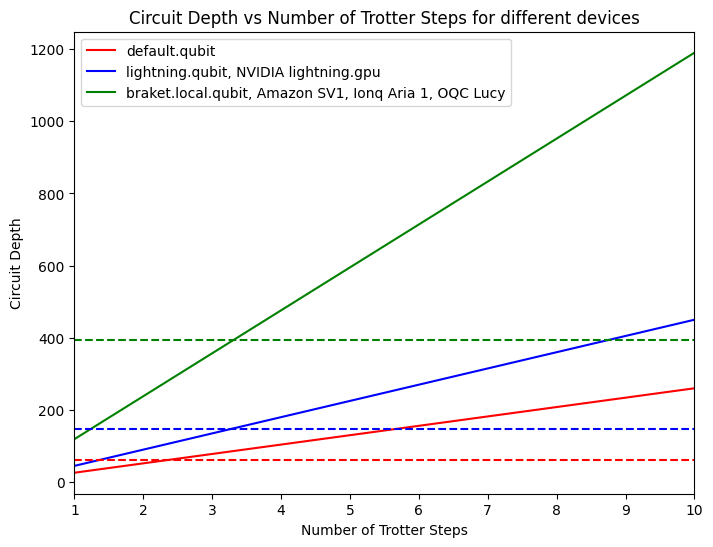

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), trotter_depths_default, label="default.qubit", color='red')
plt.plot(range(1, 11), trotter_depths_lightning, label="lightning.qubit, NVIDIA lightning.gpu", color='blue')
plt.plot(range(1, 11), trotter_depths_bracket, label="braket.local.qubit, Amazon SV1, Ionq Aria 1, OQC Lucy", color='green')

plt.axhline(y= cartan_depth_default, color='red', linestyle='--')
plt.axhline(y= cartan_depth_lightning, color='blue', linestyle='--')
plt.axhline(y= cartan_depth_local_braket, color='green', linestyle='--')

plt.xlim(1, 10)

plt.xlabel('Number of Trotter Steps')
plt.ylabel('Circuit Depth')
plt.title('Circuit Depth vs Number of Trotter Steps for different devices')
plt.legend()
plt.show()

In this graph, the horizontal dotted line corresponds to the static depth of the Cartan decomposition circuit while the full lines correspond to the increasing depth of the Trotterisation circuit in terms of the number of trotter steps used.

This graph not only gives us a basis to compare the circuit depth of the different techniques on different machines but it also allow us to benchmark the depth of the circuit of the Cartan decomposition for different devices. When we don't have a definitive value where they match, we can allow  rounding the trotter order to the nearest bigger integer. We can then compare the two algorithms at equivalent depth with a slight disadvantage for the cartan decomposition since the Trotter circuit can round to a highest depth.

In [22]:
# Here we compare the error at equivalent depth
time = np.linspace(0.5, 1000, 100) # time range

# the equivalent trotter depths
trotter_steps_default = 3
trotter_steps_lightning = 4
#trotter_steps_nvidia = 4
trotter_steps_local_braket = 4

# initialize the error arrays
cartan_error = np.zeros_like(time)
trotter_error_default = np.zeros_like(time)
trotter_error_lightning = np.zeros_like(time)
#trotter_error_nvidia = np.zeros_like(time)
trotter_error_local_braket = np.zeros_like(time)

# getting the complex exponential of the Hamiltonian 
for i in range(len(time)):
    # with cartan decomposition
    U_cartan=KHK(MolPar.kCoefs, np.multiply(MolPar.hCoefs,time[i]),MolC.k, MolC.h)
    # with the exact solution
    U_exact=exactU(MolH.HCoefs,MolH.HTuples,time[i])
    # with trotterization
    U_trotter_default = Trotter(trotter_h, time[i], qubits, trotter_steps_default)
    U_trotter_lightning = Trotter(trotter_h, time[i], qubits, trotter_steps_lightning)
    U_trotter_local_braket = Trotter(trotter_h, time[i], qubits, trotter_steps_local_braket)
    # error arrays
    cartan_error[i] = np.linalg.norm(U_exact - U_cartan)
    trotter_error_default[i] = np.linalg.norm(U_exact - U_trotter_default)
    trotter_error_lightning[i] = np.linalg.norm(U_exact - U_trotter_lightning)
    trotter_error_local_braket[i] = np.linalg.norm(U_exact - U_trotter_local_braket)

We will then plot the errors. The error made for the Cartan decomposition is the same regardless of the depth of the circuit while for the Trotter decomposition, the error is dependent on the device used when the trotter steps are not the same.

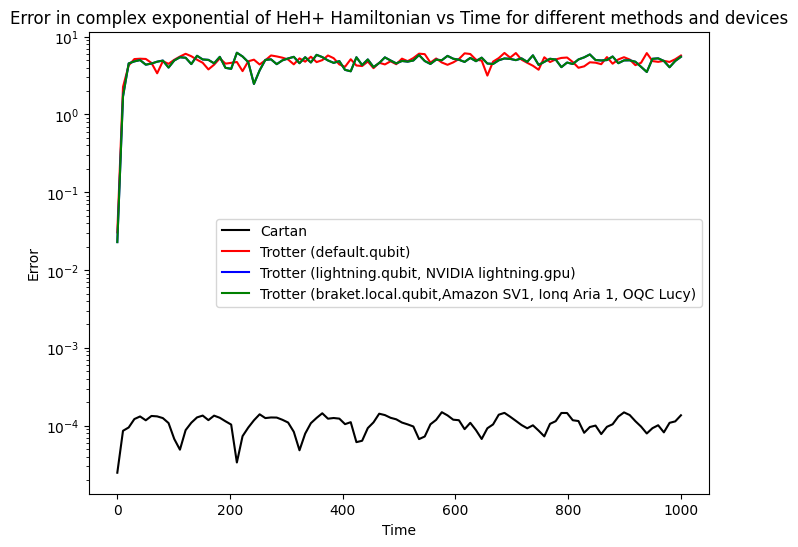

In [24]:
# plotting the errors
plt.figure(figsize=(8, 6))
plt.plot(time, cartan_error, label="Cartan", color='black')
plt.plot(time, trotter_error_default, label="Trotter (default.qubit)", color='red')
plt.plot(time, trotter_error_lightning, label="Trotter (lightning.qubit, NVIDIA lightning.gpu)", color='blue')
plt.plot(time, trotter_error_local_braket, label="Trotter (braket.local.qubit,Amazon SV1, Ionq Aria 1, OQC Lucy)", color='green')
plt.title('Error in complex exponential of HeH+ Hamiltonian vs Time for different methods and devices')

plt.yscale("log")
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()



We can clearly see that at equivalent depth over, the error of the Cartan decomposition (of order $10^{-4}$) is much smaller than that of the Trotter (of order $10^{0.5}$). This is a clear advantage of the Cartan decomposition over the Trotter decomposition, added to the fact that the Cartan decomposition has a fixed depth for a fixed number of qubits while the Trotter decomposition has an exponential scaling in terms of the order of the approximation and a linear scaling in terms of the number of trotter steps.

# Conclusion

In this project, we have illustrated that through the use of Cartan decomposition, we can produce a significantly smaller error with respect to the exact Unitary compared to the error associated with the Trotter decomposition. This implies that theoretically, we could lower the depth of the Cartan decomposition even further if we were content with a higher error.

While we have applied this Cartan decomposition to $HeH^+$, there is theoretically no issue with its implementation in other molecules, while noting that increased qubits would increase the processing time of the classical part of the algorithm, a.k.a. finding the parameters of the Cartan decomposition. Further work could involve optimizing the code to improve the efficiency of that part for a higher number of qubits.